## Подготовка к занятию 9.1

In [1]:
%pip install requests
%pip install ftfy
%pip install regex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import requests
from tqdm import tqdm

_MODEL_URL = "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt"
_VOCAB_URL = "https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz"

In [50]:
from tqdm import tqdm
from pathlib import Path

def download_file(url, n_chunk=1):
    fname = url.split('/')[-1]
    if Path(fname).exists():
        return fname
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise ValueError(str(r))
        
    block_size = 5 * 1024
    file_size = int(response.headers.get('Content-Length', None))
    num_bars = file_size // (n_chunk * block_size)
    progress_bar = tqdm(total=file_size, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    return fname

In [51]:
model_fname = download_file(_MODEL_URL)

In [52]:
vocab_fname = download_file(_VOCAB_URL)

### Занятие 9.1 Contrastive Learning Image Pretraining
https://arxiv.org/pdf/2103.00020.pdf

**Подготовка энкодера для текста**

In [53]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [54]:
tokenizer = SimpleTokenizer()
tks = tokenizer.encode("computer vision course")
tks

[11639, 652, 2515, 2613]

In [55]:
tks = tokenizer.encode("computer vision course a4cvdl")
tks

[11639, 652, 2515, 2613, 320, 275, 13531, 9373]

**Загрузка модели**

In [56]:
import torch
import numpy as np

In [65]:
model = torch.jit.load(model_fname).cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [66]:
for k, _ in model.named_children():
    print(k)

visual
transformer
token_embedding
ln_final


**Предобработка изоббражений**

In [67]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

**Скачивание тестовых изображений**

In [68]:
dog_list = [
	'https://static.wikia.nocookie.net/disney/images/0/06/Profile_-_Lady.jpeg/revision/latest?cb=20190314123153',
	'https://99px.ru/sstorage/53/2017/09/tmb_208485_1751.jpg',
	'https://mults.info/screen/pes_v_sapogah.jpg',
	'https://i.ytimg.com/vi/cedt81xIj3Q/hqdefault.jpg',
	'https://static.wikia.nocookie.net/adventuretimewithfinnandjake/images/2/2a/Hotdogpeople.png/revision/latest?cb=20120416091001',
	'https://i.pinimg.com/originals/35/00/f0/3500f0ea8dc332f61a91a5246f43317e.jpg'
]

cat_list = [
	'https://cs6.pikabu.ru/images/previews_comm/2015-05_2/1431288516433.jpg',
	'https://citaty.info/files/screenshot_25_0.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4wFdichLCRxqSw4uJbWpzwxyIopTm6hj7OQ&usqp=CAU',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2NV3JGz4zV31iYQhHwVgREcs2Mb6aiE12qA&usqp=CAU',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3dAdQaiILpBRX_HvVVHku0WHMzH6K287t5g&usqp=CAU',
	'https://i.pinimg.com/originals/d6/74/00/d67400a2fa067bb94e806f8991bc82a9.png',
	'https://topm.3dn.ru/gav1.0-04-13.jpg'
]

mice_list = [
	'https://mults.info/screen/myszka_08_koncert_swierszcza.jpg',
	'https://i.pinimg.com/originals/03/df/6b/03df6b1380d53eff6077638862e6f869.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSh41fJ_QxxghmVRcgrVzktr2tXwGZM7BgJxA&usqp=CAU'
]
penguin_list = [
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcFMVpGddNuiiCl4ilcV5GIAOg8AATAk9joA&usqp=CAU',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSxXNBxwUGYC5WF_4f648smIslDPBSuup4-7g&usqp=CAU',
	'https://i.ytimg.com/vi/i5aD4FDl9xQ/hqdefault.jpg',
	'https://b1.filmpro.ru/c/280707.700xp.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVVbNdeEafabrihdfBWjRnHwxJ27pe6o6ISQ&usqp=CAU'
]
deer_list = [
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrLXwwXu1VqSHKz6qFTLeQyNafC4jDVU841w&usqp=CAU',
	'https://i.pinimg.com/originals/84/ea/21/84ea21239cbbb349c86438021efb9f04.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2FKAmZFflAmF3x7TF4dIlyZttjhDZhs2odw&usqp=CAU'
]
pig_list = [
	'https://cs6.pikabu.ru/images/big_size_comm/2015-06_5/1434900465147582999.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSK_kH50T_mJJf42SxYYpqTDq3QBdzDoXazEw&usqp=CAU',
	'https://i.pinimg.com/originals/9d/b3/a4/9db3a479adfd6c9f9073bf239d735f57.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTqb-KXeEuK7krA0lspmEtAUHB6FoQaYbGwmQ&usqp=CAU'
 ]
fox_list = [
	'https://i.pinimg.com/originals/23/f5/ab/23f5abb963425201a60ae75c649769a5.jpg'
]
bunny_list = [
	'https://slovnet.ru/wp-content/uploads/2019/10/1-56.jpg',
	'https://i.pinimg.com/736x/43/36/3e/43363e92b72ae1a176f4da37a2d98d9c.jpg',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZ4vAXbaSboUxHPq36Ti7X01wN1zL5tEquOw&usqp=CAU',
	'https://mult-online.ru/posters/260_347_90_1/uploads/posts/2011-05/thumbs/1305554431_zayac-iz-nu-pogodi.jpg'
]
wolf_list = [
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnrjUbgx0T6qniCkO8m6-6wDmn1rzM2hy0OA&usqp=CAU',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQL8WJitB_yODJK06J4vjmRtVFG8iX5Uj-rqg&usqp=CAU'
 ]
lion_list = [
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYAPtYJJP4qcqJB3duR4-Mnk9at8VGq_Nb4g&usqp=CAU',
	'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFLJdo3JEE9lY_goArQy0nRBIgZXVefB8c3g&usqp=CAU',
	'https://i.pinimg.com/originals/d5/85/c7/d585c741a26d76d0a0a49a01c1ce33db.jpg',
	'https://i.pinimg.com/originals/1d/d6/e8/1dd6e82e565b95d2c623282d94ec70d7.jpg'
]

In [74]:
from PIL import Image
from tqdm import tqdm
import requests


per_class_lists = [dog_list, cat_list, mice_list, penguin_list, deer_list,
                   pig_list, fox_list, bunny_list, wolf_list, lion_list]

images = []
one_per_class = []

ses = requests.Session()
ad = requests.adapters.HTTPAdapter(max_retries=2)
ses.mount('http://', ad)

for per_class_list in tqdm(per_class_lists):
    for id, url in enumerate(per_class_list):
        try:
            im = Image.open(ses.get(url, stream=True, timeout=10).raw)
            image = preprocess(im)
            if image.shape[0] != 3:
                raise TypeError("Only 3-channel RGB image are allowed")
            images.append(image)
            if id == 0:
                one_per_class.append(image)
        except Exception as exc:
            print(f"error: {id}) {url}: {str(exc)}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


**Составим описания изображений**

Так как мы хотим предсказывать класс без обучения, то составим ему текстовое описание таким образом, чтобы их представления в признаковом пространстве были как можно ближе.

In [75]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

descriptions = {
    "Dog": "This is a painting of cartoon dog",
    "Cat": "This is a painting of cartoon cat",
    "Mice": "This is a painting of cartoon rat or mice",
    "Penguin": "This is a painting of cartoon penguin",
    "Deer": "This is a painting of cartoon deer",
    "Pig": "This is a painting of cartoon pig",
    "Fox": "This is a painting of cartoon fox",
    "Bunny": "This is a painting of cartoon hare or bunny", 
    "Wolf": "This is a painting of cartoon wolf",
    "Lion": "This is a painting of cartoon lion"
}

texts = [descriptions[key] for key in descriptions]

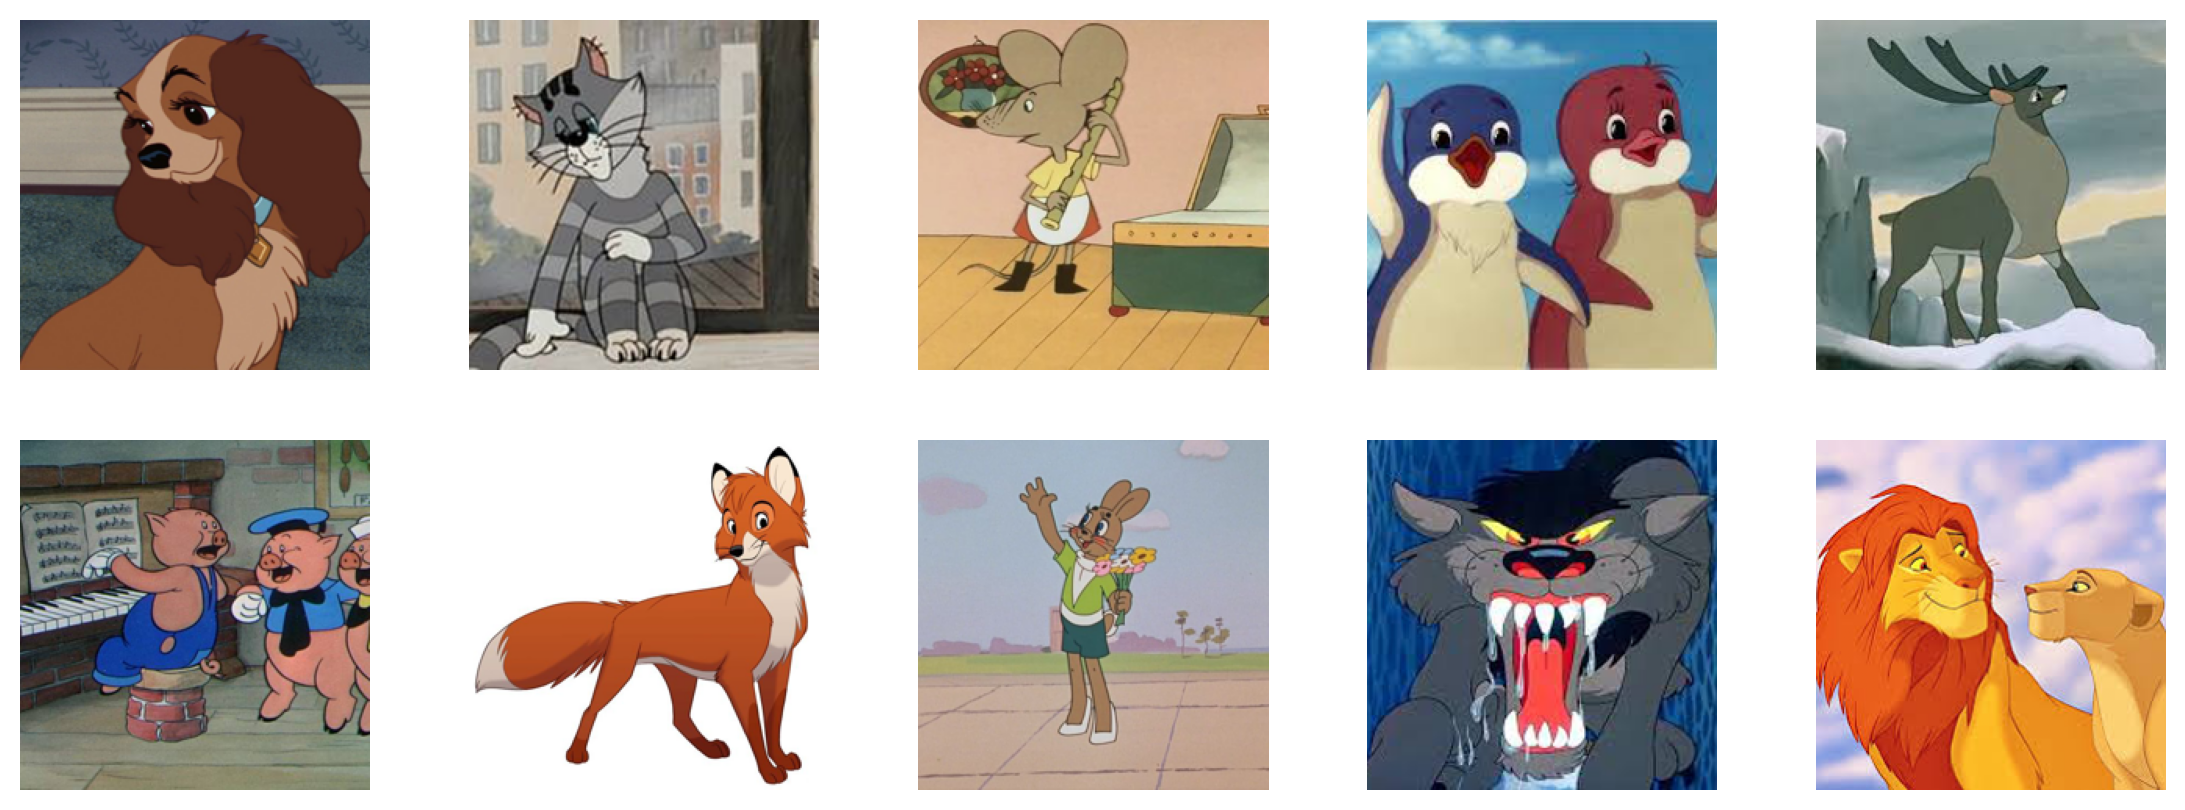

In [76]:
plt.figure(figsize=(14, 5))

for i, (image, key) in enumerate(zip(one_per_class, descriptions)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")


In [77]:
image_input = torch.tensor(np.stack(one_per_class)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [78]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode(desc) for desc in texts]

In [79]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [80]:
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [81]:
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in texts]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

torch.Size([10, 77])

**Предсказание классов**

Для каждой картинки получим вектор признаков и сравним его с векторами для текстов по косинусному расстоянию.

In [86]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

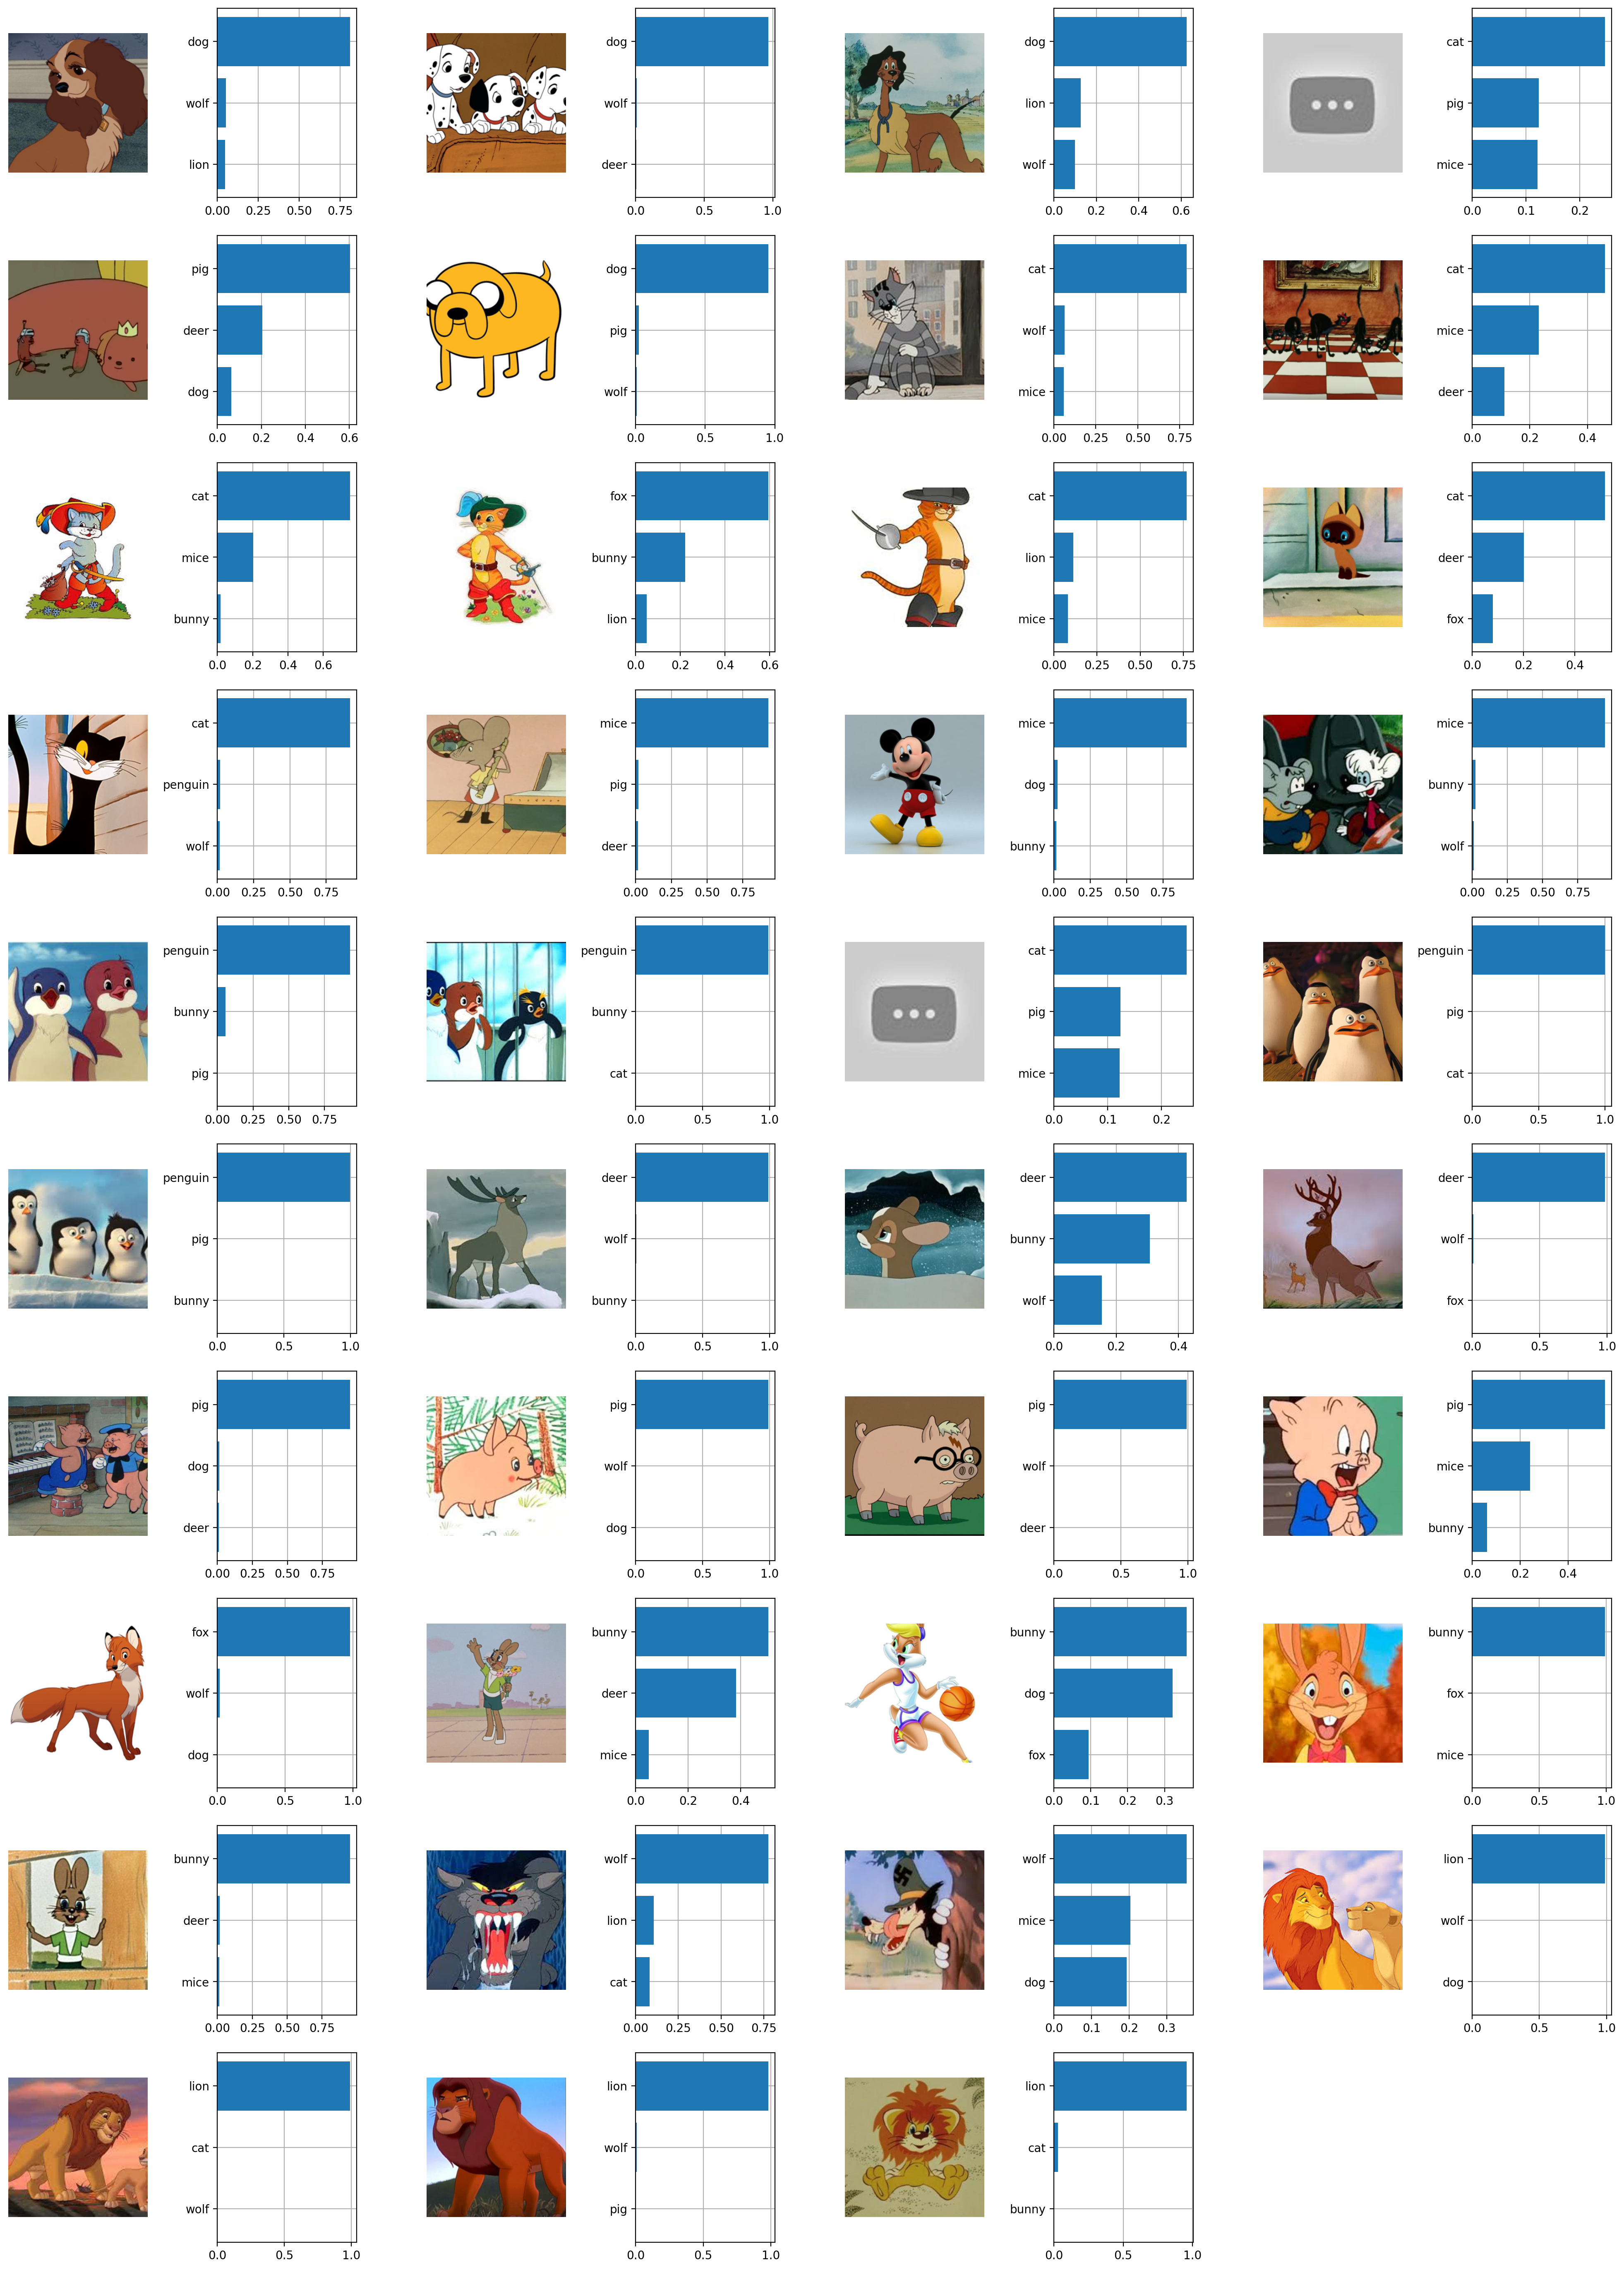

In [87]:
plt.figure(figsize=(25, 60))

for i, image in enumerate(images):
    plt.subplot(17, 8, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(17, 8, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [texts[index].split(' ')[-1] for index in top_labels[i].numpy()])

plt.subplots_adjust(wspace=0.5)
plt.show()